# Stage 3: Ensemble

# 1. Preprocessing 

## 1.1 Loading the data

In [1]:
# Imports
import os
import time
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
import shutil
from data.util import *
from data.transformer import * 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE,RFECV #importing RFE class from sklearn library
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import validation_curve
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# load training and testing data into memory
root_path = "data"
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()
X_test = TestDataLoader(root_path).load()
X_train, s_train, y_train_str, p_train, i_train = TrainDataLoader(root_path).load()

# X_train: all features (pixels x 3) of all training samples (4146)
# s_train: superclasses of all samples (4146); note ordered
# y_train: classes of all samples (4146); note ordered
# p_train: pole IDs of all samples (4146)
# i_train: indices of all samples (4146); note duplicates
# X_test: all features (pixels x 3) of all testing samples (4293)

# Make sure that you properly encode the CLASSES such that 
# the order in your submission files is correct!
label_enc = LabelEncoder()
label_enc.fit(CLASSES)
y_train = label_enc.transform(y_train_str) # numerical labels
    
# Randomizer
numpy_seed = 0
python_seed = 0
np.random.seed(numpy_seed)
random.seed(python_seed)

In [3]:
# display some numbers
number_of_train_samples = len(X_train)
number_of_classes = len(np.unique(y_train))
number_of_test_samples = len(X_test)
print('number of training samples:', number_of_train_samples)
print('number of testing samples:', number_of_test_samples)
print('number of labels:', number_of_classes)

number of training samples: 4146
number of testing samples: 4293
number of labels: 81


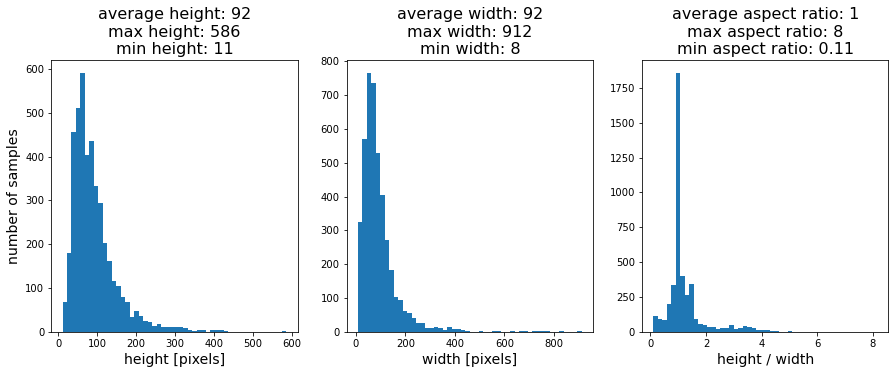

In [4]:
height_arr, width_arr = np.zeros(number_of_test_samples), np.zeros(number_of_test_samples)
for idx, sample in enumerate(X_test):
    height, width, rgb = sample.shape
    height_arr[idx] = height
    width_arr[idx] = width
fig_size, ax_size = plt.subplots(1,3, figsize=(15,5))
ax_size[0].set_ylabel('number of samples', fontsize=14)
ax_size[0].set_title('average height: {}\nmax height: {}\nmin height: {}'.format(
    round(np.average(height_arr)), round(np.max(height_arr)), round(np.min(height_arr))), fontsize=16)
ax_size[1].set_title('average width: {}\nmax width: {}\nmin width: {}'.format(
    round(np.average(width_arr)), round(np.max(width_arr)), round(np.min(width_arr))), fontsize=16)
ax_size[2].set_title('average aspect ratio: {}\nmax aspect ratio: {}\nmin aspect ratio: {}'.format(
    round(np.average(height_arr / width_arr)), round(np.max(height_arr / width_arr)), round(np.min(height_arr / width_arr), 2)), fontsize=16)
ax_size[0].set_xlabel('height [pixels]', fontsize=14)
ax_size[1].set_xlabel('width [pixels]', fontsize=14)
ax_size[2].set_xlabel('height / width', fontsize=14)
plot_histogram(ax_size[0], height_arr, 50)
plot_histogram(ax_size[1], width_arr, 50)
plot_histogram(ax_size[2], height_arr / width_arr, 50)

## 1.2 Class distribution

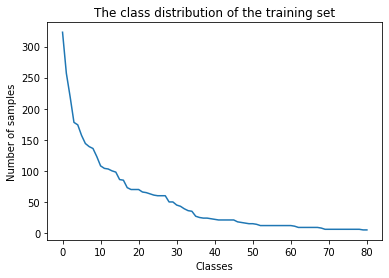

In [5]:
# Create a plot showing the class distribution in the training set
fig_distr, ax_distr = plt.subplots()
ax_distr.set_title("The class distribution of the training set")
ax_distr.set_xlabel("Classes")
ax_distr.set_ylabel("Number of samples")

count = countOcc(y_train)
plt.plot([i for i in range(len(count))], count);
fig_distr.savefig(os.path.join('visualization','class_distribution.png'))

## 1.3 Improve contrast (CLAHE)

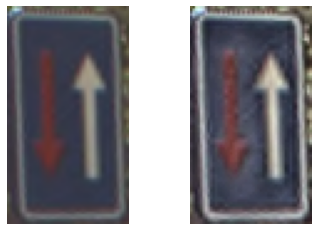

In [6]:
X_train_contr = ContrastTransformer().transform(X_train)
X_test_contr = ContrastTransformer().transform(X_test)

# Show effect of improving contrast
image_index = 1
image_ori = Image.fromarray(X_train[image_index])
image_con = Image.fromarray(X_train_contr[image_index])

# create figure and show images
fig_con, ax_con = plt.subplots(1,2)
ax_con[0].imshow(image_ori)
ax_con[1].imshow(image_con)
ax_con[0].set_axis_off()
ax_con[1].set_axis_off()

## 1.4 Resize all images to a fixed resolution

(4146, 128, 128, 3)
(4293, 128, 128, 3)


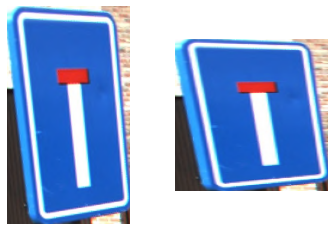

In [70]:
X_train_resized = ResizeTransformer(size=128).transform(X_train)
X_test_resized = ResizeTransformer(size=128).transform(X_test)
print(X_train_resized.shape)
print(X_test_resized.shape)

# Show effect of resizing
image_index = 17
image_ori = Image.fromarray(X_train[image_index])
image_res = Image.fromarray(X_train_resized[image_index])
# create figure and show images
fig_res, ax_res = plt.subplots(1,2)
ax_res[0].imshow(image_ori)
ax_res[1].imshow(image_res)
ax_res[0].set_axis_off()
ax_res[1].set_axis_off()

# 2. Feature Extraction

## 2.1. Aspect Ratio

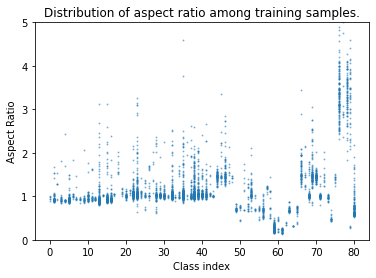

In [8]:
aspect_ratio = [get_ratio(img) for img in X_train]

plt.ylim(0,5)
plt.xlabel("Class index")
plt.ylabel("Aspect Ratio")
plt.title("Distribution of aspect ratio among training samples.")
plt.scatter(y_train, aspect_ratio, alpha=0.42, s=1)

## 2.1. Color Histograms

(4146, 64)
(4293, 64)


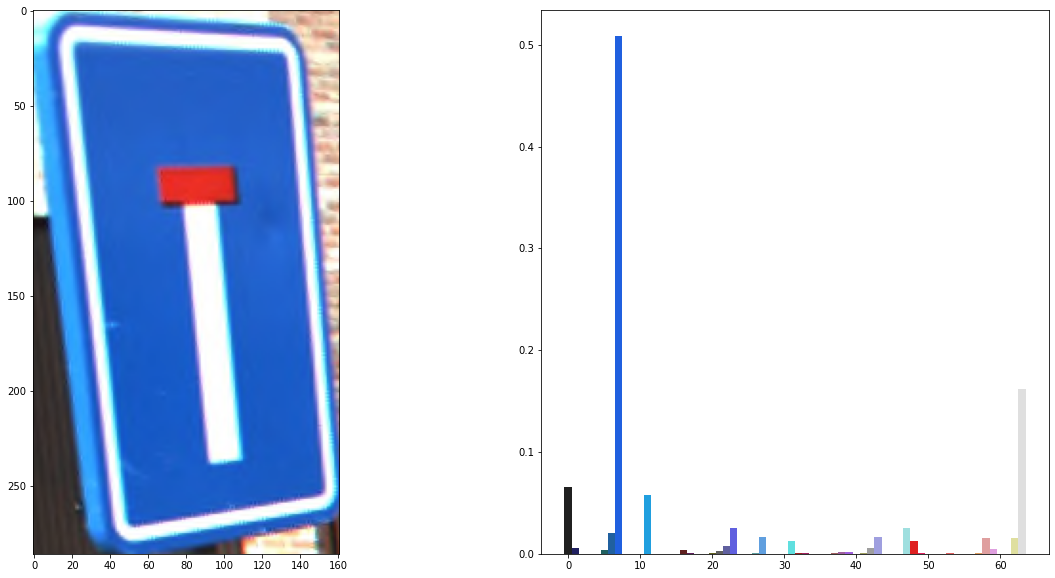

In [36]:
nbinh=4
X_train_hist = colorhistTransformer(nbin=nbinh).transform(X_train)
X_test_hist = colorhistTransformer(nbin=nbinh).transform(X_test)
print(X_train_hist.shape)
print(X_test_hist.shape)

def image_plot(hist,image,colors):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(len(hist)),hist,width=1,color=colors,linewidth=0)
colors=[]
for r in np.arange(0.5,nbinh+0.5):
    for g in np.arange(0.5,nbinh+0.5):
        for b in np.arange(0.5,nbinh+0.5):
            colors.append((r/nbinh,g/nbinh,b/nbinh))
image_plot(X_train_hist[image_index],X_train[image_index],colors*256)

## 2.2 HOG features

In [72]:
X_train_hog = HogTransformer(winSize=128, blockSize=128, blockStride=128, cellSize=32, nbins=5).transform(X_train_resized)
X_test_hog = HogTransformer(winSize=128, blockSize=128, blockStride=128, cellSize=32, nbins=5).transform(X_test_resized)
print(X_train_hog.shape)
print(X_test_hog.shape)

(4146, 80)
(4293, 80)


# 3. Feature Visualization

## 3.1 Histogram for 1 HOG feature
A histogram that plots the number of samples with certain HOG values for 1 specific HOG feature.

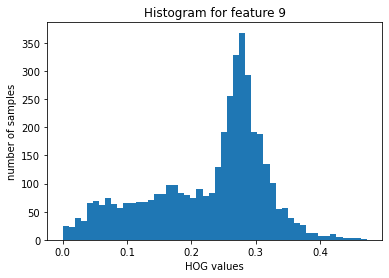

In [11]:
# Visualize the histogram for a specific feature
feature_index = 9
feature = X_train_hog[:,feature_index]
fig_feat, ax_feat = plt.subplots()
ax_feat.set_title("Histogram for feature {}".format(feature_index))
ax_feat.set_xlabel("HOG values")
ax_feat.set_ylabel("number of samples")
plot_histogram(ax_feat, feature, bins=50)

## 3.2 HOG features for 1 sample

(576,)


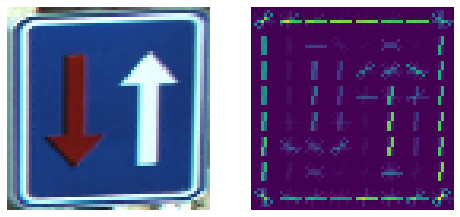

In [12]:
# visualization of HOG features (NOTE: uses skimage HOG)
from skimage.feature import hog

image_index = 7
image_original = X_train_resized[image_index]
fd, image_hog = hog(image_original, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(8, 8), visualize=True, multichannel=True)

fig_hog, ax_hog = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax_hog[0].imshow(image_original)
ax_hog[1].imshow(image_hog)
ax_hog[0].set_axis_off()
ax_hog[1].set_axis_off()
print(fd.shape)

## 3.3 Color histogram for 1 sample
A histogram that plots the number of features with certain HOG values for 1 specific sample. There's also a function implemented to plot histograms for multiple samples. This is to visually check for correlations between samples and try to understand what the poleIDs and IDs play as roles in the dataset.
Note that samples with different poleIDs but identical IDs have (visually) identical histograms. This implies a correlation between these samples.

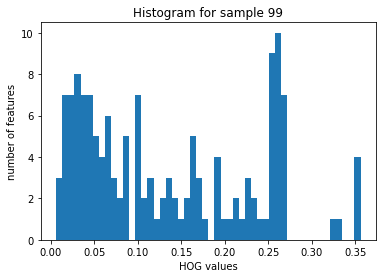

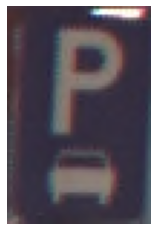

In [13]:
# Visualize the histogram for a specific sample
sample_index = 99
sample = X_train_hog[sample_index,:]
image = Image.fromarray(X_train[sample_index])
#image.show() # uncomment to show corresponding images
fig_samp, ax_samp = plt.subplots()
ax_samp.set_title("Histogram for sample {}".format(sample_index))
ax_samp.set_xlabel("HOG values")
ax_samp.set_ylabel("number of features")
plot_histogram(ax_samp, sample, bins=50)
fig_im, ax_im = plt.subplots()
ax_im.imshow(image)
ax_im.set_axis_off()

## 3.4. Feature Combination
Combine HOG and color features.

In [37]:
X_train_hog_hist = np.concatenate((X_train_hog, X_train_hist), axis=1)
X_test_hog_hist = np.concatenate((X_test_hog, X_test_hist), axis=1)
print(X_train_hog_hist.shape)
print(X_test_hog_hist.shape)

(4146, 640)
(4293, 640)


## 3.4. Feature Correlations
We can also look at the correlations between feature pairs. Multiple correlation coefficient calculation methods are possible.

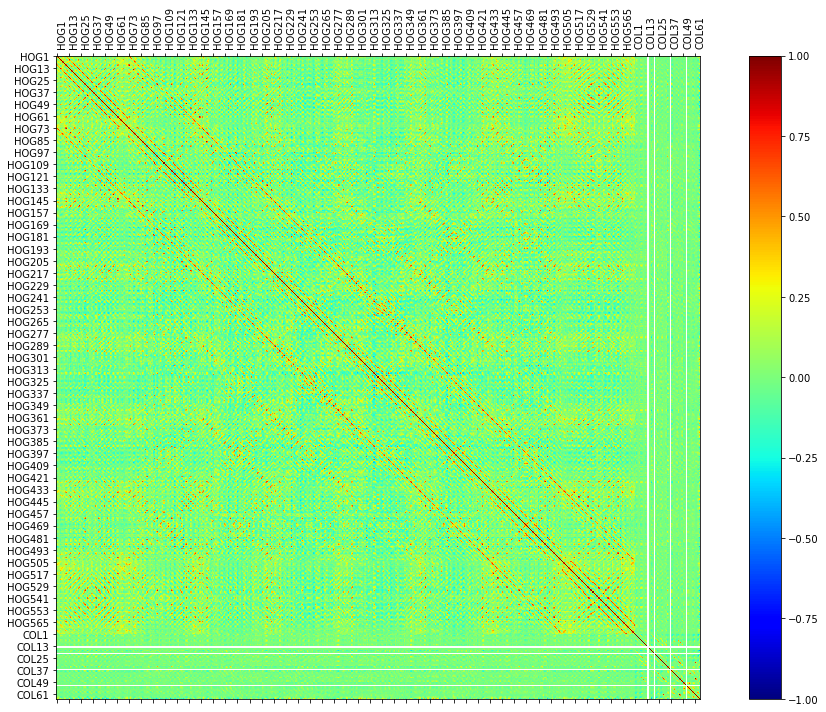

In [38]:
# We can also look at the correlations between feature pairs 
# and between the features and the labels

# turn numpy X_train into pd dataframe and add column with labels
row_names = [i for i in range(1,number_of_train_samples+1)]
column_names = ['HOG'+ str(i) for i in range(1,X_train_hog.shape[1]+1)]
column_names += ['COL' + str(i) for i in range(1,nbinh**3+1) ]
pd_X_train_hog_hist = pd.DataFrame(data=X_train_hog_hist, 
                                  index=row_names,
                                        columns=column_names)
pd_X_train_hog_hist['class'] = y_train
pd_X_train_hog_hist.head()
plot_correlation_matrix(pd_X_train_hog_hist)

In [16]:
# You can check the # of ftrs eleminated by transformming 
for t in [.75]:#,.8,.85,.9
    X_train_corrTrunc = CorrMatrixTransformer(treshold=t).transform(X_train_hog, y_train)
    print(f'Threshold value {t}')
    print(X_train_corrTrunc.shape)

Using Correlation matrix: removed 17 features.
Threshold value 0.75
(4146, 128)


# 4. Pipeline

In [19]:
# cross validation strategy -- stratified and grouped
cv_indices = []
folds = 5
sgkf = stratified_group_k_fold(X_train, y_train, p_train, k=folds)
for fold_number, (train_fold, test_fold) in enumerate(sgkf):
    cv_indices.append((train_fold, test_fold))
    #show_classes_in_fold(y_train, train_fold, test_fold, fold_number)

In [114]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# calculate amount of samples per class
# add (over) or (under) subtract to a specific number
# class_counts can be used as sampling_strategy!
min_samples = 20
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
for y, count in class_counts.items():
    if count < min_samples:
        class_counts[y] += min_samples - count
        
usample = RandomUnderSampler(sampling_strategy='auto', 
                              random_state=None, replacement=False)
X_ures, y_ures = usample.fit_resample(X_train_hog_hist, y_train)
print(X_ures.shape)

osample = RandomOverSampler(sampling_strategy=class_counts, random_state=None)

X_ores, y_ores = osample.fit_resample(X_train_hog_hist, y_train)
print(X_ores.shape)

(405, 640)
(4500, 640)


In [118]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import BaggingClassifier
import imblearn.pipeline as pl

# different pipeline sections
pipeline_hog = Pipeline([('resize', ResizeTransformer(size=128)),
                        ('hog', HogTransformer(winSize=128, blockSize=128, blockStride=128, cellSize=32, nbins=5))
                        ])
pipeline_colorhist = Pipeline([('colorhist', colorhistTransformer(nbin=4))])
pipeline_aspect_ratio = Pipeline([('aspect_ratio', AspectRatioTransformer())])

# combinated
union = FeatureUnion([('HOG', pipeline_hog), 
                     ('COLOR', pipeline_colorhist),
                     ('REST', pipeline_aspect_ratio)
                     ])

estimator = pl.Pipeline([('feature', union),
                    ('scalar', StandardScaler()),
                    ('resample', RandomUnderSampler(sampling_strategy='auto', random_state=None)),
                    ('classify_ensemble', BaggingClassifier(
                        base_estimator=LogisticRegression(C=0.1, max_iter=1000), 
                        n_estimators=10, max_samples=1.0, max_features=1.0, 
                        bootstrap=False, bootstrap_features=False, oob_score=False, warm_start=False, 
                        n_jobs=-3, random_state=None, verbose=0))
                    ])

#estimator = EasyEnsembleClassifier(n_estimators=100, base_estimator=linear_model, 
#                                   warm_start=False, sampling_strategy='auto', 
#                                   replacement=True, n_jobs=-3, random_state=None, verbose=0)

scores = cross_validate(estimator, X_train, y_train, groups=p_train, n_jobs=-3,
                        cv=cv_indices, scoring=neg_logloss_scorer, return_train_score=True)
show_scores(scores)

Training score -1.581184708298974 +/- 0.290670666225245
Cross-validation score: -1.8194963640962485 +/- 0.22738481428661583


# 5. Model Evaluation

## 5.1. Validation Curve

In [ ]:
# validation curve for 1 dimensional grid search, any hyperparameter
# Note: this performs a gridsearch and is very slow
param_name = 'classify_lr__C'
param_range = param_grid[param_name]
valid_curv = validation_curve(estimator, X_train, y_train, param_name=param_name, param_range=param_range, 
                                cv=cv_indices, groups=p_train, scoring=neg_logloss_scorer, 
                                    n_jobs=-2)
plot_validation_curve(valid_curv, param_name, param_range, xscale="log")

## 5.2. Learning Curve

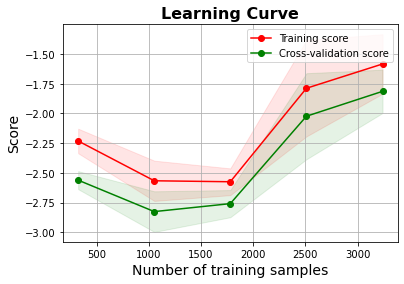

In [119]:
# calculate and plot learning curve
learn_curv = learning_curve(estimator, X_train, y_train, train_sizes=np.linspace(.1, 1.0, 5),
                                cv=cv_indices, groups=p_train, scoring=neg_logloss_scorer, 
                                    n_jobs=-2, shuffle=True)
plot_learning_curve(learn_curv)

## 5.3. Misclassifications

number of misclassified images: 446
number of shown misclassified images: 47


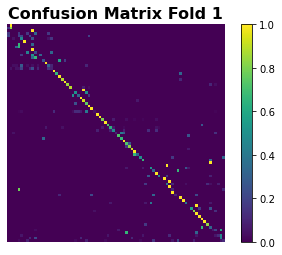

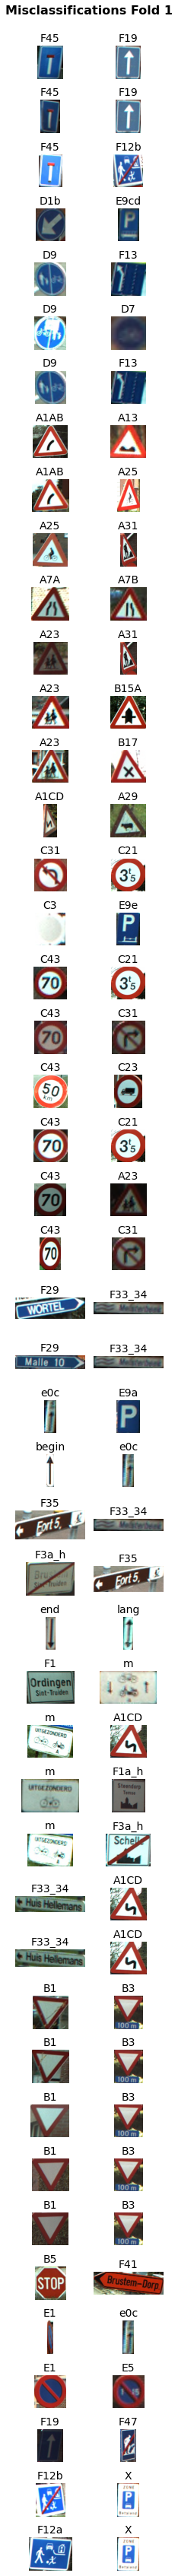

In [120]:
# calculate and plot confusion matrix and corresponding misclassified images for a certain fold
show_misclassifications(estimator, X_train, y_train, cv_indices, fold_number=1, N=47)

In [68]:
fold_number = 1
train_indices, test_indices = cv_indices[fold_number-1]
# train estimator on training data
estimator.fit(np.array(X_train, dtype=object)[train_indices], y_train[train_indices])
# predict class on cross-validation data
y_pred = estimator.predict(np.array(X_train, dtype=object)[test_indices])
y_true = y_train[test_indices]
# plot confusion matrix for this fold
conf_matr = confusion_matrix(y_true, y_pred, normalize=None) # not normalised

class #misclassifications validation #images validation #images total
A15 2 3 6
A1AB 1 6 24
A1CD 2 5 17
A25 2 3 9
A29 3 3 9
A7A 1 6 21
B7 3 3 6
C1 3 36 178
C11 1 3 15
C3 4 15 70
C43 1 65 323
E7 1 3 12
E9a_miva 1 6 23
E9cd 2 2 8
F25 5 5 12
F27 3 3 16
F29 1 24 123
F35 3 3 5
F4a 2 22 104
begin 2 29 144
e0c 2 3 11


/Users/a_gemmel/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


lang 2 9 43


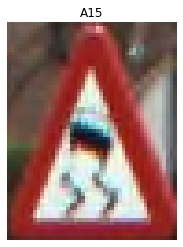

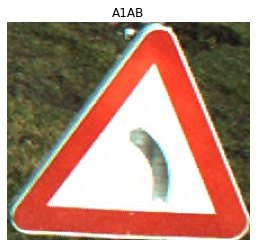

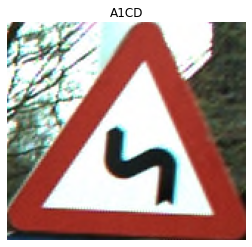

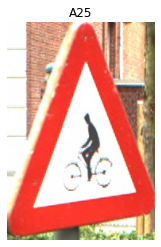

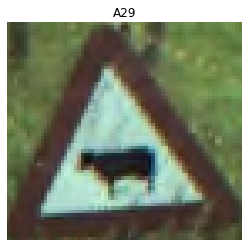

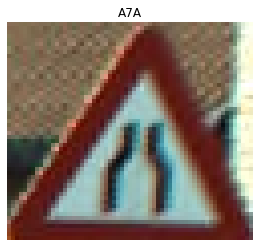

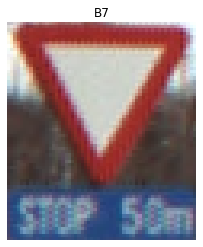

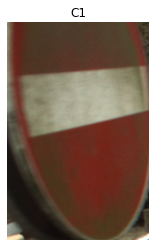

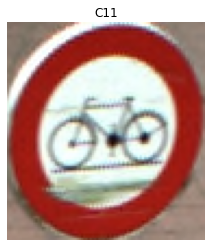

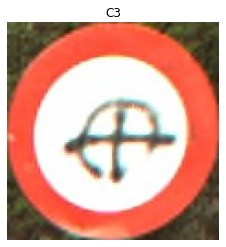

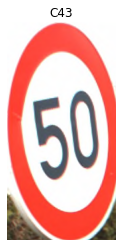

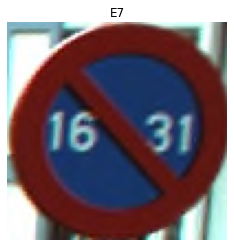

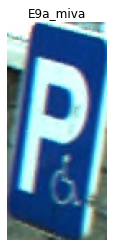

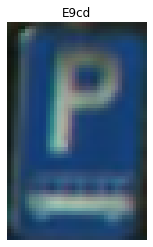

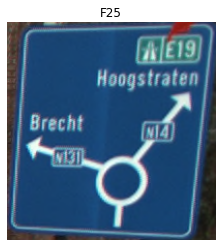

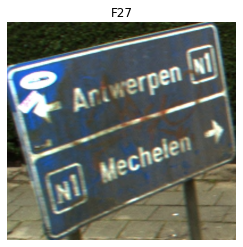

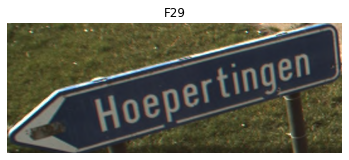

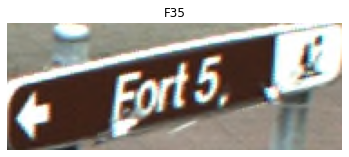

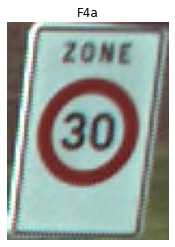

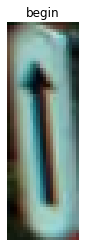

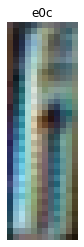

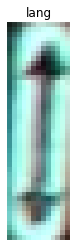

In [78]:
print('class', '#misclassifications validation', '#images validation', '#images total')
for idx, y in enumerate(conf_matr):
    # calculate total misclassifications this fold
    tot_miscl = sum(y) - y[idx] # don't count diagonal element (correct classification)
    if tot_miscl != 0:
        fig, ax = plt.subplots()
        tot_idx_fold = len(np.where(y_train[test_indices] == idx)[0])
        print(CLASSES[idx], tot_miscl, tot_idx_fold, len(np.where(y_train == idx)[0]))
        image = X_train[np.where(y_train == idx)[0][0]]
        ax.set_title(CLASSES[idx])
        ax.imshow(image)
        ax.set_axis_off()

# 6. Submission

In [28]:
# train best model using all training data
estimator.fit(X_train, y_train)
# Here is where we create the submission for your estimator
output_probabilities = estimator.predict_proba(X_test)
create_submission(output_probabilities, 'submission.csv')